
# ISYS2407 Information Systems Solutions & Design

# Assignment 3

# Model 2 Selected Feature

#### Student name: Rajbeer Kohli

#### Student number: s3798453


# 1 Import libraries

In [23]:
# Import the library for pickling
import joblib

# Library needed for counting categorical values
import collections

# Also need pandas here
import pandas as pd

import numpy as np
from sklearn.model_selection import GridSearchCV

# Library to scale values
from sklearn.preprocessing import StandardScaler

# Library for replacing labels with numbers
from sklearn.preprocessing import LabelEncoder

# Libary needed for onehot encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
# Just use pandas get_dummies which is a lot easier to use

# Library for splitting the data into train and test sets
from sklearn.model_selection import train_test_split 

# Import the model library
from sklearn.linear_model import LogisticRegression

# Import the libraries for computing the metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# Import the plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# 2 Load the cleaned data

#### Pickled file must exist in your folder

In [24]:
# Load the pickled file
attrition_df = joblib.load('attrition-cleaned.pkl')  

# Check
attrition_df.head()

,age,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_count,employee_number,environment_satisfaction,...,standard_hours,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager,attrition
0,41.0,Travel_Rarely,1102.0,Sales,1.0,2.0,Life Sciences,1.0,1.0,2.0,...,80.0,0.0,8.0,3.0,1.0,6.0,4.0,0.0,5.0,1
1,49.0,Travel_Frequently,279.0,Research & Development,8.0,1.0,Life Sciences,1.0,2.0,3.0,...,80.0,1.0,10.0,3.0,3.0,10.0,7.0,1.0,7.0,0
2,37.0,Travel_Rarely,1373.0,Research & Development,2.0,2.0,Other,1.0,4.0,4.0,...,80.0,0.0,7.0,3.0,3.0,0.0,0.0,0.0,0.0,1
3,33.0,Travel_Frequently,1392.0,Research & Development,3.0,4.0,Life Sciences,1.0,5.0,4.0,...,80.0,0.0,8.0,3.0,3.0,8.0,7.0,3.0,0.0,0
4,27.0,Travel_Rarely,591.0,Research & Development,2.0,1.0,Medical,1.0,7.0,1.0,...,80.0,1.0,6.0,3.0,3.0,2.0,2.0,2.0,2.0,0


# 3 Split the data into training and testing set

In [25]:
# Storing the features in variable X (uppercase as there are multiple features)

feature_cols = ['age', 
'daily_rate',  
'distance_from_home',
'employee_number',           
'hourly_rate', 
'job_involvement',
'job_satisfaction',
'monthly_income', 
'monthly_rate',
'stock_option_level',
'total_working_years',
'years_at_company',
'years_in_current_role',
'years_with_curr_manager']

X = attrition_df[feature_cols]
#print('X:\n', X)

# Store the labels/target in variable y (lower case as its a single value)
y = attrition_df['attrition']
#print('y:\n', y)

# Split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # keep 20% for testing
                                                    random_state=2 # pass an int for reproducible rtesult
                                                    )

# 4 Data Transformations to improve modelling performance

#### Should be performed after the data has been split into training and testing sets to prevent information leakage (train-test contamination)

## 4.1 Scale the columns with continuous values

In [26]:
# 1. Select the columns to scale

columns_to_scale = ['age', 
'daily_rate',  
'distance_from_home',
'employee_number',           
'hourly_rate', 
#'job_involvement',
#'job_satisfaction',
'monthly_income', 
'monthly_rate',
#'stock_option_level',
'total_working_years',
'years_at_company',
'years_in_current_role',
'years_with_curr_manager']


# 2. Make copy of the training and testing sets fix the issue below
# Warning: A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead
X_train = X_train.copy()
X_test = X_test.copy()

# 3. Instantiate a scaler
scaler = StandardScaler()
    
# 4. Fit the scaler on the training column and transform the training and testing columns
# Use a loop to scale all the required columns    
for col in columns_to_scale:
    #print(col)
    # First fit the scaler to the column in the training data
    # Must reshape the numpy array returned b the scaler from 1D to 2D
    scaler.fit(X_train[col].values.reshape(-1, 1))
    # Then transform both the training and testing sets
    X_train[col] = scaler.transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

# Check
print(X_train.shape, X_test.shape)

(1176, 14) (294, 14)


## 4.2 Discretization of continuous variables

In [27]:
# When checking the number of unique values, the blood pressure column was found to contain 47 values
# This is evidence that it's a continuous variable

# Some classification algorithms do not work well with continuous values - too many values
# So, depending on the classification algorithm you are usind, you might need to categorise these values
# How? Need some domain knowlege
# For blood pressure we could use the following:
# less than 80 = normal, between 80-89 = high, greater than 89 = very high

# Define a function to classify this
# Pass the whole dataframe as parameter
# And return a category (a word label but you could also return numeric labels)
# NOTE: Do not create too many categories as this will affect the learning algorithms
def income(df): 
    if df["monthly_income"] <= 3500:
        return "below_avg"
    elif df["monthly_income"] > 3500:
        return "above_average"

In [28]:
# Apply the  previously defined function to the training set

# Use apply() to apply a lambda function for all the rows of the dataframe
# The lambda function calls the previously defined function bp_category()
# To which it passes the diabetes_df as parameter
# And a category is returned and saved in a new column named "blood_pressure_category"
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
# the backslash is a line continuation character - there should be nothing after it, not even a space

# Warning: A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead
# Below is another fix - make a copy
X_train = X_train.copy()
X_train["monthly_income_category"] = \
    X_train.apply(lambda X_train:income(X_train), axis = 1) # axis=1 = row-wise

# The column "blood_pressure" is no longer needed and hence can be deleted 
X_train.drop(['monthly_income'], axis=1, inplace=True)

# Check
X_train.head()

,age,daily_rate,distance_from_home,employee_number,hourly_rate,job_involvement,job_satisfaction,monthly_rate,stock_option_level,total_working_years,years_at_company,years_in_current_role,years_with_curr_manager,monthly_income_category
285,0.020782,1.397274,-1.017288,-1.040644,-1.164539,3.0,4.0,0.215234,0.0,1.066259,2.900775,2.401104,0.886660,below_avg
194,0.901489,0.964352,-0.893162,-1.251719,-0.023456,2.0,4.0,0.855546,1.0,1.857377,-0.182432,1.198763,1.181796,below_avg
323,-0.970013,0.871408,-0.893162,-0.959205,0.919177,1.0,4.0,1.453087,0.0,-0.832422,-0.696300,-0.604749,-0.589016,below_avg
1015,-0.309483,-0.588787,-1.017288,0.687848,1.266463,3.0,1.0,0.830666,2.0,-0.041305,-0.439366,-0.304164,-0.293880,below_avg
1003,-1.300279,0.362663,-1.017288,0.661256,0.770340,3.0,4.0,-1.318245,1.0,-0.515975,-0.696300,-0.604749,-0.589016,below_avg


In [29]:
# Apply the  previously defined function to the testing set
X_test = X_test.copy()
X_test["monthly_income_category"] = \
    X_test.apply(lambda X_test:income(X_test), axis = 1) # axis=1 = row-wise

# The column "blood_pressure" is no longer needed and hence can be deleted 
X_test.drop(['monthly_income'], axis=1, inplace=True)

# Check
X_test.head()

,age,daily_rate,distance_from_home,employee_number,hourly_rate,job_involvement,job_satisfaction,monthly_rate,stock_option_level,total_working_years,years_at_company,years_in_current_role,years_with_curr_manager,monthly_income_category
721,1.451931,0.338204,1.837621,-0.020169,1.464912,3.0,3.0,-1.422937,1.0,1.857377,1.616106,2.100518,0.296390,below_avg
843,-1.190190,1.426624,-0.769035,0.265697,0.819953,4.0,4.0,-0.128614,1.0,-0.357752,0.588370,0.898177,0.886660,below_avg
627,1.672108,0.218356,1.961748,-0.249526,0.770340,2.0,4.0,0.655108,0.0,-0.041305,0.845304,1.198763,-1.179286,below_avg
1368,-0.309483,-0.160757,1.589368,1.520516,1.018402,2.0,4.0,1.698952,0.0,0.908036,2.386907,1.799933,2.067201,below_avg
305,-0.089306,0.744222,1.837621,-0.994107,-0.916477,3.0,2.0,-1.036317,1.0,0.116919,0.845304,1.198763,1.181796,below_avg


In [30]:
# 1. Select the columns to label encode
# Make sure they are categorical columns containing word labels as label encoding will convert them to numeric labels
# If the categories are numbers, then no need to label encode!
# Better list all the columns and comment out the ones you don't need
columns_to_encode = [
    #'age', 
    #'daily_rate',  
    #'employee_number',           
    #'hourly_rate', 
    #'job_involvement', 
    'monthly_income_category', 
    #'monthly_rate',
    #'stock_option_level',
    #'total_working_years',
    #'years_at_company',
    #'years_in_current_role',
    #'years_with_curr_manager'
]

# 2. Make copy of the training and testing sets fix the issue below
# Warning: A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead
X_train = X_train.copy()
X_test = X_test.copy()

# 3. Instantiate a LabelEncoder
encoder = LabelEncoder()

# 4. Fit the encoder on the training column and transform the training and testing columns
# Use a loop to label encode all the required columns 
for col in columns_to_encode:
    # First fit the encoder to the training data
    encoder.fit(X_train[col])
    # Then transform both the training and the testing sets
    X_train[col] = encoder.transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

# Check
X_train.head()

,age,daily_rate,distance_from_home,employee_number,hourly_rate,job_involvement,job_satisfaction,monthly_rate,stock_option_level,total_working_years,years_at_company,years_in_current_role,years_with_curr_manager,monthly_income_category
285,0.020782,1.397274,-1.017288,-1.040644,-1.164539,3.0,4.0,0.215234,0.0,1.066259,2.900775,2.401104,0.886660,0
194,0.901489,0.964352,-0.893162,-1.251719,-0.023456,2.0,4.0,0.855546,1.0,1.857377,-0.182432,1.198763,1.181796,0
323,-0.970013,0.871408,-0.893162,-0.959205,0.919177,1.0,4.0,1.453087,0.0,-0.832422,-0.696300,-0.604749,-0.589016,0
1015,-0.309483,-0.588787,-1.017288,0.687848,1.266463,3.0,1.0,0.830666,2.0,-0.041305,-0.439366,-0.304164,-0.293880,0
1003,-1.300279,0.362663,-1.017288,0.661256,0.770340,3.0,4.0,-1.318245,1.0,-0.515975,-0.696300,-0.604749,-0.589016,0


In [31]:
# Check
X_test.head()

,age,daily_rate,distance_from_home,employee_number,hourly_rate,job_involvement,job_satisfaction,monthly_rate,stock_option_level,total_working_years,years_at_company,years_in_current_role,years_with_curr_manager,monthly_income_category
721,1.451931,0.338204,1.837621,-0.020169,1.464912,3.0,3.0,-1.422937,1.0,1.857377,1.616106,2.100518,0.296390,0
843,-1.190190,1.426624,-0.769035,0.265697,0.819953,4.0,4.0,-0.128614,1.0,-0.357752,0.588370,0.898177,0.886660,0
627,1.672108,0.218356,1.961748,-0.249526,0.770340,2.0,4.0,0.655108,0.0,-0.041305,0.845304,1.198763,-1.179286,0
1368,-0.309483,-0.160757,1.589368,1.520516,1.018402,2.0,4.0,1.698952,0.0,0.908036,2.386907,1.799933,2.067201,0
305,-0.089306,0.744222,1.837621,-0.994107,-0.916477,3.0,2.0,-1.036317,1.0,0.116919,0.845304,1.198763,1.181796,0


## 4.3 Other data transformations e.g. label encoding, scaling, etc

In [32]:
## 4.2 One-hot encoding of columns with multiple categories

#### Note: Since one-hot encoding generates lots of dummy variables (columns), this has an impact on certain machine learning algorithms - only use when justified (need to experiment to find out)

# 5 Modelling

## 5.1 Initial/baseline model

### 5.1.1 Fit initial model

In [33]:
# Import the model library
from sklearn.neighbors import KNeighborsClassifier

# Instantiate model and fit on training data
knn_model = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

# Predict using test data
y_pred = knn_model.predict(X_test)

# Quick check
print(y_pred[:5])

[0 0 0 0 0]


### 5.1.2 Evaluate model

accuracy: 0.8503401360544217
precision: 0.6428571428571429
recall: 0.1875
F1 score: 0.2903225806451613
[[241   5]
 [ 39   9]]


<AxesSubplot:>

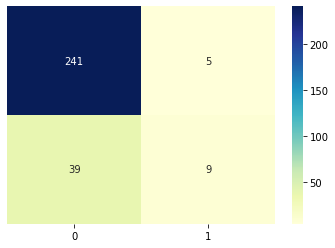

In [34]:
# Compute performance metrics of the baseline model

accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy}")

precision = precision_score(y_test, y_pred)
print(f"precision: {precision}") 

recall = recall_score(y_test, y_pred)
print(f"recall: {recall}") 

f1  = f1_score(y_test, y_pred)
print(f"F1 score: {f1 }") 

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
# Visualise the   confusion matrix
sns.heatmap(cf_matrix, annot=True, fmt="d", yticklabels=False, cmap="YlGnBu")


# Continue with the rest of the modelling steps - e.g.

## 5.2 Improved model

### 5.2.1 Use grid search to find best hyperameters (details in grid search notebook)

In [35]:
# List of relevant params
#  n_estimators: int, default=100
#  criterion: {"gini", "entropy"}, default="gini"
#  max_depth: int, default=none
#  min_samples_split: int or float, default=2
#  min_samples_leaf: int or float, default=1
#  min_weight_fraction_leaf: float, default=0.0
#  max_features: {"auto", "sqrt", "log2"}, int or float, default="auto"
#  max_leaf_nodes: int, default=None

param_grid = [
    {"n_neighbors": range(1,50)},
    {"n_neighbors": range(1,50), "weights": ["uniform", "distance"]}
]

# Instantiate a grid search object and fit it to the training data
clf = KNeighborsClassifier()
grid = GridSearchCV(clf, param_grid, verbose=0,cv=5, scoring='f1')
grid.fit(X_train, y_train)
print(f"Best params: {grid.best_params_}, score {grid.best_score_:0.2f}")

Best params: {'n_neighbors': 1}, score 0.25


### 5.2.2 Fit improved model

In [36]:
# Import the model library
from sklearn.neighbors import KNeighborsClassifier

# Instantiate model and fit on training data
knn_model = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

# Predict using test data
y_pred = knn_model.predict(X_test)

# Quick check
print(y_pred[:5])

[0 0 0 0 0]


#### 5.2.3 Evaluate  improved model

accuracy: 0.8503401360544217
precision: 0.6428571428571429
recall: 0.1875
F1   score: 0.2903225806451613
[[241   5]
 [ 39   9]]


<AxesSubplot:>

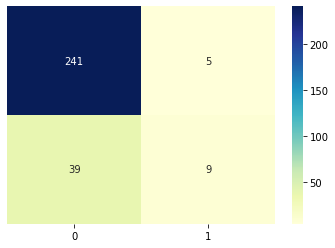

In [37]:
# 1.  Compute metrics

accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy}")

precision = precision_score(y_test, y_pred)
print(f"precision: {precision}") 

recall = recall_score(y_test, y_pred)
print(f"recall: {recall}") 

f1  = f1_score(y_test, y_pred)
print(f"F1   score: {f1 }") 

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
# Visualise the   confusion matrix
sns.heatmap(cf_matrix, annot=True   , fmt  ="d"  , yticklabels=False, cmap   ="YlGnBu")

# 6 Save the model for further evaluation (in another notebook)
#### Should also save the train/test sets

In [ ]:

# Pickle the model for later evaluation
joblib.dump(rf_model, 'model-2-sel.pkl')  # Use the right model name and a suitable file name

# Also need to pickle the training and testing sets
joblib.dump(X_train, 'X_train.pkl') 
joblib.dump(X_test, 'X_test.pkl') 
joblib.dump(y_train, 'y_train.pkl') 
joblib.dump(y_test, 'y_test.pkl')

# Note: make sure that the model and the training/testing sets match 
# i.e. the model was built using this particular training set
# and the testing set matches this partiular training
